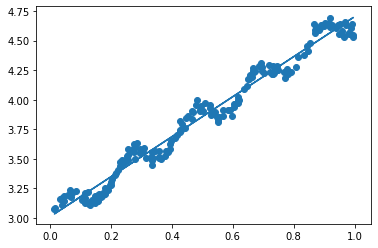

相关系数： [[1.         0.98647356]
 [0.98647356 1.        ]]


In [25]:
#..........................案例1:
#..........................线性回归
import numpy as np
# 线性回归，OLS，根据w=(XTX)-1XTy来计算
# 数据中加入一列1，即为截距
def standRegres(xArr,yArr):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    xTx = xMat.T*xMat
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T*yMat)
    return ws
import pandas as pd
file=r'C:\Users\Wudey\Desktop\machinelearninginaction\Ch08\ex0.txt'
file1=r'C:\Users\Wudey\Desktop\machinelearninginaction\Ch08\abalone.txt'
dta=pd.read_table(file,header=None)
dta,label=dta.iloc[:,:-1],dta.iloc[:,-1]
ws=standRegres(dta,label)
yhat=np.mat(dta)*ws # 矩阵
yhat=yhat.flatten().A[0] # 。A的用法
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(dta.iloc[:,1],label) # 原本的线
ax.plot(dta.iloc[:,1],yhat)
plt.show()
print("相关系数：",np.corrcoef(label,yhat))

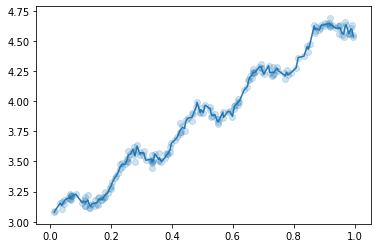

均方误差： 0.06865982933147709
测试均方误差： 0.10293971489285804


In [26]:
#..........................案例2:
#..........................局部线性回归
#...........从图中可以看到，案例1中似乎有些规律没有挖掘出来，
#...........给每个点一定的权重，常用的高斯核：wi=exp(-|xi-x|/2k^2)，越近权重越大
#..局部加权线性回归函数,任意给定一点，求预测值，权重的赋予类似KNN
def lwlr(testPoint,xArr,yArr,k=1.0):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    weights = np.mat(np.eye((m)))
    for j in range(m):                      #next 2 lines create weights matrix
        diffMat = testPoint - xMat[j,:]     #
        weights[j,j] = np.exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * (weights * xMat)
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws
def lwlrTest(testArr,xArr,yArr,k=1.0):  #loops over all the data points and applies lwlr to each one
    testArr=np.mat(testArr)
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat
yhat=lwlrTest(dta,dta,label,0.003) # k=0.003,感觉有些过拟合
x=dta.iloc[:,1]
xs=x.argsort() # 排序
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(x,label,alpha=0.2) # 原本的线
ax.plot(x[xs],yhat[xs])
plt.show()
# 可以用均方误差来判断训练效果
def rssError(yArr,yHatArr): #yArr and yHatArr both need to be arrays
    return ((yArr-yHatArr)**2).sum()
print("均方误差：",rssError(label,yhat))
# 均方误差很小但是，它在测试集里的表现可能并不好。
# 方便取材，用dta构造测试数据
dta_t=pd.concat([dta.iloc[100:190,:],dta.iloc[0:100,:],dta.iloc[0:100,:]],axis=0)
lble_t=label[100:190].append(label[0:100]).append(label[0:100])
yhat=lwlrTest(dta_t,dta,label,0.003)
print("测试均方误差：",rssError(lble_t,yhat))
# k的值，这里没有进行调整去找最佳，但是以上能发现一个问题：每次测试都需要把训练数据带上，计算量与KNN类似，很大

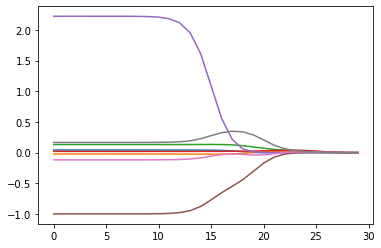

In [27]:
#..........................案例3:
#..........................特征比样本数多，此时XXT是非奇异的，上述无法计算
#............引入λ，w=(XTX+λI)^-1XTy，称之为岭回归，最先用于处理特征比样本数，现在也用于在估计中加入偏差。
#............这里通过引入λ来限制了所有w之和，通过引入该惩罚项，能够减少不重要的参数，这个技术叫做缩减（shrinkage）。
dta=pd.read_table(file1,header=None)
dta,label=dta.iloc[:,:-1],dta.iloc[:,-1]
# 岭回归
# 计算回归系数
def ridgeRegres(xMat,yMat,lam=0.2):
    xTx = xMat.T*xMat
    denom = xTx + np.eye(np.shape(xMat)[1])*lam
    if np.linalg.det(denom) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T*yMat)
    return ws
# 计算不同lam的结果，注意为了进行比较，将数据进行标准化
def ridgeTest(xArr,yArr,numTestPts = 30):
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean     #to eliminate X0 take mean off of Y
    #regularize X's
    xMeans = np.mean(xMat,0)   #calc mean then subtract it off
    xVar = np.var(xMat,0)      #calc variance of Xi then divide by it
    xMat = (xMat - xMeans)/xVar
    wMat = np.zeros((numTestPts,np.shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat,yMat,np.exp(i-10))
        wMat[i,:]=ws.T
    return wMat
ridg=ridgeTest(dta,label) # 30个岭回归结果(权重)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(ridg) # 不同log(λ)下的回归系数,λ很小时与线性回归类似，λ很大时，缩减为0，寻找最佳λ
plt.show()

In [28]:
#..........................案例4:
#..........................其他的缩减方法，lasso、LAR、PCA回归以及子集选择等
#...........lasso回归：限定Σ|w|<=λ。计算会很复杂
#...........一个更为简单的方法来得到结果，该方法叫做前向逐步回归，与lasso效果类似
# 向前逐步回归
# 标准化
def regularize(xMat):#regularize by columns
    inMat = xMat.copy()
    inMeans = np.mean(inMat,0)   #calc mean then subtract it off
    inVar = np.var(inMat,0)      #calc variance of Xi then divide by it
    inMat = (inMat - inMeans)/inVar
    return inMat
# 对每个系数每次改变一个微小的值（正或者负），看均方误差的变化，寻找最优
def stageWise(xArr,yArr,eps=0.01,numIt=100):
    # eps步长，numIt迭代次数
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean     #can also regularize ys but will get smaller coef
    xMat = regularize(xMat)
    m,n=np.shape(xMat)
    returnMat = np.zeros((numIt,n)) #testing code remove
    ws = np.zeros((n,1)); wsMax = ws.copy()
    for i in range(numIt):
        # print(ws.T)
        lowestError = np.inf
        for j in range(n):
            for sign in [-1,1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign # 改变一个微小的值
                yTest = xMat*wsTest
                rssE = rssError(yMat.A,yTest.A) # 均方误差
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i,:]=ws.T
    return ws,returnMat
ws,mat=stageWise(dta,label,0.01,200)
print("权重变化（不怎么变化，可能没啥影响；来回震荡可能是步长太大）：\n",mat)

权重变化（不怎么变化，可能没啥影响；来回震荡可能是步长太大）：
 [[ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 ...
 [ 0.05  0.    0.09 ... -0.64  0.    0.36]
 [ 0.04  0.    0.09 ... -0.64  0.    0.36]
 [ 0.05  0.    0.09 ... -0.64  0.    0.36]]


回归系数： [[1.79371535]
 [3.03116944]]
第一行的预测结果： [[1.64104004]]
the best model from Ridge Regression is:
 [[1.84152602]]
with constant term:  [[3.03146826]]


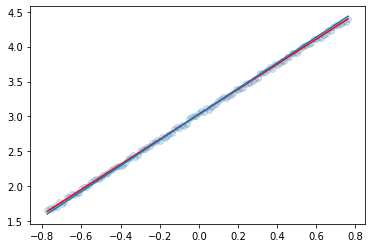

In [53]:
#..........................案例5:
#..........................权衡偏差与方差，相比于简单回归，缩减会增加偏差，减少方差，需要进行测试误差最小化
# 构造数据：
import random
x=[i/80 for i in range(-62,62)]
y=[3+1.7*xi+0.1*np.sin(xi)+0.06*random.random() for xi in x]
# 构造模型：
# 加截距项
x1=pd.DataFrame(x)
x1['con']=1
# 标准回归：
ws0=standRegres(x1,y)
print('回归系数：',ws0)
print('第一行的预测结果：',list(x1.iloc[0,:])*ws0)
yhat=np.mat(x1)*ws0
# 岭回归(交叉验证,测试误差最小化)：
def crossValidation(xArr,yArr,numVal=10):
    # numVal交叉验证的次数，注意到因为训练集和测试集不确定，每次结果是不一样的，多次求均值
    m = len(yArr)
    indexList = list(range(m))
    errorMat = np.zeros((numVal,30))#create error mat 30columns numVal rows
    for i in range(numVal):
        # 分训练集和测试集
        trainX=[]; trainY=[]
        testX = []; testY = []
        np.random.shuffle(indexList) # 打乱索引
        for j in range(m): #create training set based on first 80% of values in indexList
            if j < m*0.8:
                trainX.append(list(xArr.iloc[indexList[j],:]))
                trainY.append(yArr[indexList[j]])
            else:
                testX.append(list(xArr.iloc[indexList[j],:]))
                testY.append(yArr[indexList[j]])
        # 测试集训练
        wMat = ridgeTest(trainX,trainY)    #30个岭回归的结果
        for k in range(30): # loop over all of the ridge estimates
            matTestX = np.mat(testX); matTrainX=np.mat(trainX)
            meanTrain = np.mean(matTrainX,0)
            varTrain = np.var(matTrainX,0)
            matTestX = (matTestX-meanTrain)/varTrain #regularize test with training params
            yEst = matTestX * np.mat(wMat[k,:]).T + np.mean(trainY)#test ridge results and store
            # 计算均方误差
            errorMat[i,k]=rssError(yEst.T.A,np.array(testY))
            #print errorMat[i,k]
    meanErrors = np.mean(errorMat,0) #calc avg performance of the different ridge weight vectors
    minMean = float(min(meanErrors))
    bestWeights = wMat[np.nonzero(meanErrors==minMean)]
    #can unregularize to get model
    #when we regularized we wrote Xreg = (x-meanX)/var(x)
    #we can now write in terms of x not Xreg:  x*w/var(x) - meanX/var(x) +meanY
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    meanX = np.mean(xMat,0); varX = np.var(xMat,0)
    unReg = bestWeights/varX
    print("the best model from Ridge Regression is:\n",unReg)
    # 注意截距的计算
    con=-1*sum(np.multiply(meanX,unReg)) + np.mean(yMat)
    print("with constant term: ",con)
    return unReg,con
unreg,con=crossValidation(pd.DataFrame(x),y)
yhat1=unreg*x+con
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(x,y,alpha=0.2) # 原本的线
ax.plot(x,yhat,c='r')
ax.plot(x,yhat1.T.tolist())
plt.show()
# 两条线几乎重合，但是在特征比较多的情况下，可能效果比较明显
# 特征较多时，可以用ridgeTest()查看哪些特征是有效的